In [2]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider

In [4]:

# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

from keras import backend as K

Using TensorFlow backend.


In [5]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

print("There are %d training data with size %d x %d" %x_train0.shape)
print("There are %d testing  data with size %d x %d" %x_test0.shape)

There are 60000 training data with size 28 x 28
There are 10000 testing  data with size 28 x 28


In [6]:
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

## Autoencoder

In [7]:
x = Input(shape=(784,))

enc_1 = Dense(100, activation='sigmoid')
enc_2 = Dense(2, activation='sigmoid')

h = enc_2(enc_1(x))

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

x_hat = dec_1(dec_2(h))

In [8]:
autoencoder = Model(x, x_hat)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               79184     
Total params: 158,186
Trainable params: 158,186
Non-trainable params: 0
_________________________________________________________________


In [9]:
autoencoder.compile(loss='mse', optimizer=Adam())

In [10]:
autoencoder.fit(x_train, x_train, batch_size=1024, epochs=100)

Epoch 1/100
60000/60000 [==============================] - 3s 45us/step - loss: 0.1130
Epoch 2/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.0702
Epoch 3/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.0684
Epoch 4/100
60000/60000 [==============================] - 2s 31us/step - loss: 0.0679
Epoch 5/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.0677
Epoch 6/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.0676
Epoch 7/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.0675
Epoch 8/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.0674: 0s - loss:
Epoch 9/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.0674
Epoch 10/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.0674
Epoch 11/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.0674
Epoch 12/100
60000/60000 [===

In [11]:

Encoder = Model(x, h)
Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [13]:
h_input = Input(shape=(2,))
Decoder = Model(h_input, dec_1(dec_2(h_input)))
Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [14]:
idx = 5998
Encoder.predict(x_train[idx:idx+1])

array([[0.5706538 , 0.23732738]], dtype=float32)

In [15]:
indices = np.random.randint(10000, size=3000)

In [16]:
latent = Encoder.predict(x_test[indices])

In [17]:
latent.shape

(3000, 2)

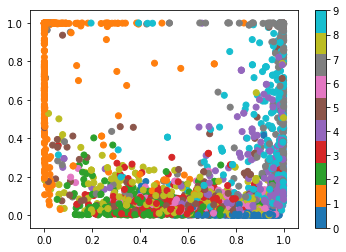

In [18]:
plt.scatter(latent[:, 0], latent[:, 1],c=y_test0[indices],cmap='tab10')
plt.colorbar()

In [19]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

In [20]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(n-i-1) * digit_size: (n - i) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

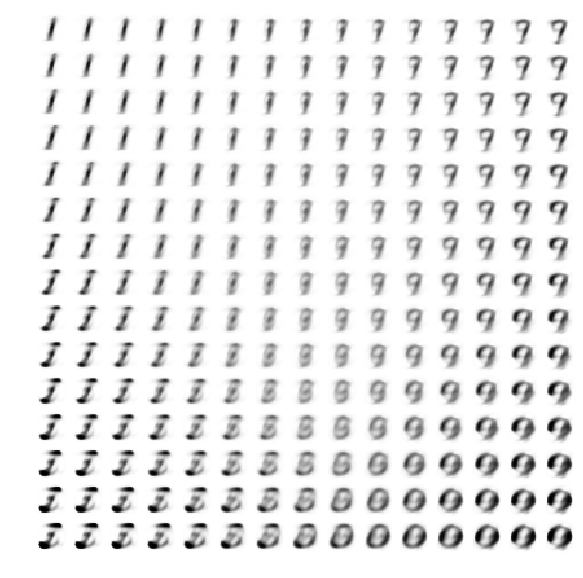

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys')
plt.axis('off')
plt.show()

In [22]:
enc_1 = Dense(100, activation='sigmoid')
# enc_2 = Dense(2, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [23]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [24]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [25]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [26]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)